# (05) Ellipsoid -- geom

**Motivation**: Look at the geometry of the representations. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# Code path
sys.path.insert(0, '/home/hadi/Documents/MTMST/code')
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
def ellipsoid_rd(s: np.ndarray):
    sum2 = sum(s**2)
    radius = np.sqrt(sum2)
    dim = sum(s) ** 2 / sum2
    return radius, dim

## Setup

In [3]:
fig_dir = pjoin(fig_base_dir, 'rebuttal_aug')
print(fig_dir)

path = pjoin(tmp_dir, 'trainer_analysis')
pal_model, pal_cat = get_palette()

/home/hadi/Dropbox/git/jb-MTMST/figs/rebuttal_aug

In [4]:
skip_fits = [
    'fixate1_nf-420_beta-0.8_(2023_05_07,04:15)',
    'fixate1_nf-420_beta-20.0_(2023_05_08,16:16)',
    'fixate1_nf-420_beta-0.001_(2023_05_16,00:03)',
    'vanilla_fixate1_nf-420_beta-0.001_(2023_05_16,08:26)',
]
category = 'fixate1'
betas = None # [0.9, 1.0]

files = sorted([
    f for f in os.listdir(path) if category in f and 
    (any(f"beta-{b}" in f for b in betas) if betas else True)
    and f.replace('.npy', '') not in skip_fits
])
print(files)

[
    'fixate1_nf-420_beta-0.01_(2023_04_30,07:42).npy',
    'fixate1_nf-420_beta-0.15_(2023_04_27,20:20).npy',
    'fixate1_nf-420_beta-0.1_(2023_04_29,22:01).npy',
    'fixate1_nf-420_beta-0.2_(2023_04_30,21:37).npy',
    'fixate1_nf-420_beta-0.3_(2023_05_07,01:03).npy',
    'fixate1_nf-420_beta-0.4_(2023_05_07,02:37).npy',
    'fixate1_nf-420_beta-0.5_(2023_04_30,20:05).npy',
    'fixate1_nf-420_beta-0.6_(2023_04_30,20:36).npy',
    'fixate1_nf-420_beta-0.7_(2023_04_30,21:40).npy',
    'fixate1_nf-420_beta-0.8_(2023_05_13,14:52).npy',
    'fixate1_nf-420_beta-0.9_(2023_05_07,05:51).npy',
    'fixate1_nf-420_beta-1.0_(2023_04_29,19:41).npy',
    'fixate1_nf-420_beta-1.5_(2023_05_08,14:55).npy',
    'fixate1_nf-420_beta-10.0_(2023_04_30,22:48).npy',
    'fixate1_nf-420_beta-2.0_(2023_05_07,07:27).npy',
    'fixate1_nf-420_beta-5.0_(2023_05_07,08:59).npy',
    'fixate1_nf-420_beta-ae_(2023_05_12,07:31).npy',
    'vanilla_fixate1_nf-420_beta-0.01_(2023_05_13,21:48).npy',
    'vanilla_fixate1_nf-420_beta-0.15_(2023_05_02,15:15).npy',
    'vanilla_fixate1_nf-420_beta-0.1_(2023_05_10,21:14).npy',
    'vanilla_fixate1_nf-420_beta-0.2_(2023_05_10,23:41).npy',
    'vanilla_fixate1_nf-420_beta-0.3_(2023_05_13,07:46).npy',
    'vanilla_fixate1_nf-420_beta-0.4_(2023_05_11,19:25).npy',
    'vanilla_fixate1_nf-420_beta-0.5_(2023_05_07,02:51).npy',
    'vanilla_fixate1_nf-420_beta-0.6_(2023_05_12,18:12).npy',
    'vanilla_fixate1_nf-420_beta-0.7_(2023_05_12,08:53).npy',
    'vanilla_fixate1_nf-420_beta-0.8_(2023_05_11,02:19).npy',
    'vanilla_fixate1_nf-420_beta-0.9_(2023_05_13,20:45).npy',
    'vanilla_fixate1_nf-420_beta-1.0_(2023_05_07,01:18).npy',
    'vanilla_fixate1_nf-420_beta-1.5_(2023_05_14,14:16).npy',
    'vanilla_fixate1_nf-420_beta-10.0_(2023_05_09,09:59).npy',
    'vanilla_fixate1_nf-420_beta-2.0_(2023_05_09,08:19).npy',
    'vanilla_fixate1_nf-420_beta-5.0_(2023_05_15,07:23).npy',
    'vanilla_fixate1_nf-420_beta-ae_(2023_05_13,07:49).npy'
]

In [5]:
thres = 0.1
df = []
for f in tqdm(files):
    *_, beta, model = extract_info(f)
    
    x = pjoin(path, f)
    x = np.load(x, allow_pickle=True).item()
    z = np.concatenate([
        x['data_vld']['z'],
        x['data_tst']['z'],
    ])

    s = sp_lin.svdvals(z)
    r, d = ellipsoid_rd(s)
    s /= sum(s)
    
    if 'kl_diag' in x['loss']:
        n_active = x['loss']['kl_diag'] > thres
        n_active = n_active.sum()
    else:
        n_active = np.nan

    measures = {
        'radius': r,
        'dimensionality': d,
        'dimensionality_normalized': d / 11,
        'radius_normalized': ellipsoid_rd(s)[0],
        'n_90_var': np.where(np.cumsum(s) > 0.9)[0][1],
        'n_active_kl_normalized': n_active / 11,
        'n_active_kl': n_active,
    }
    df.append({
        'model': [model] * len(measures),
        'beta': [beta] * len(measures),
        'measure': measures.keys(),
        'value': measures.values(),
    })

df = pd.DataFrame(merge_dicts(df))

100%|███████████████████████████████████████████| 34/34 [06:45<00:00, 11.93s/it]


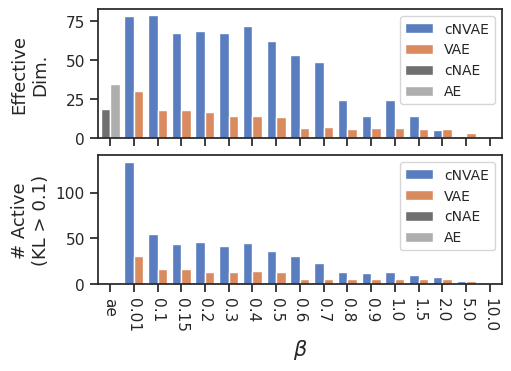

In [6]:
betas = get_betas(df)
measures = [
    'dimensionality',
    'n_active_kl',
]
fig, axes = create_figure(
    len(measures), 1,
    (5, 1.8 * len(measures)),
    sharex='all',
    layout='constrained',
)

_df = df.loc[df['beta'] != 'ae']
_df_ae = df.loc[df['beta'] == 'ae']
_pal = {
    k: v for k, v in pal_model.items()
    if k in _df['model'].unique()
}
_pal_ae = {
    k: v for k, v in pal_model.items()
    if k in _df_ae['model'].unique()
}
for i, m in enumerate(measures):
    ax = axes.flat[i]
    sns.barplot(
        data=_df.loc[_df['measure'] == m],
        x='beta',
        y='value',
        hue='model',
        palette=_pal,
        order=betas,
        ax=ax,
    )
    sns.barplot(
        data=_df_ae.loc[_df_ae['measure'] == m],
        x='beta',
        y='value',
        hue='model',
        palette=_pal_ae,
        order=betas,
        ax=ax,
    )
    ax.set(xlabel='', ylabel='')
    leg = ax.get_legend()
    sns.move_legend(ax, 'upper right', fontsize=10, title='')
    
axes[0].set_ylabel('Effective\nDim.', labelpad=12, fontsize=13)
axes[1].set_ylabel('# Active\n(KL > 0.1)', fontsize=13)
axes[1].set_xlabel(r"$\beta$", fontsize=15)    
axes[1].tick_params(axis='x', rotation=-90)

# fig.savefig(pjoin(fig_dir, 'dim_kl-active.pdf'), bbox_inches='tight')
plt.show()

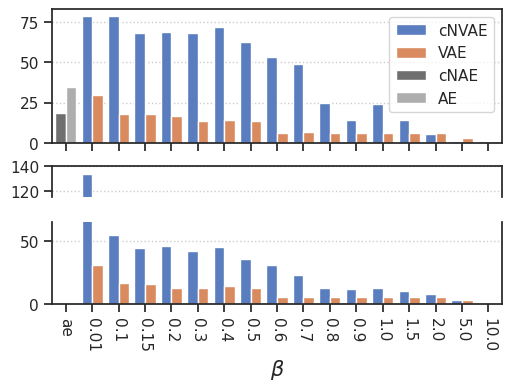

In [58]:
betas = get_betas(df)
measures = [
    'dimensionality',
    'n_active_kl',
    'n_active_kl',
]
fig, axes = create_figure(
    nrows=4,
    ncols=1,
    figsize=(5, 3.8),
    sharex='none',
    layout='constrained',
    height_ratios=[1.3, 0.3, 0.05, 0.8],
)

_df = df.loc[df['beta'] != 'ae']
_df_ae = df.loc[df['beta'] == 'ae']
_pal = {
    k: v for k, v in pal_model.items()
    if k in _df['model'].unique()
}
_pal_ae = {
    k: v for k, v in pal_model.items()
    if k in _df_ae['model'].unique()
}
for i, m in enumerate(measures):
    if i == 2:
        i = 3
    ax = axes.flat[i]
    sns.barplot(
        data=_df.loc[_df['measure'] == m],
        x='beta',
        y='value',
        hue='model',
        palette=_pal,
        order=betas,
        ax=ax,
    )
    sns.barplot(
        data=_df_ae.loc[_df_ae['measure'] == m],
        x='beta',
        y='value',
        hue='model',
        palette=_pal_ae,
        order=betas,
        ax=ax,
    )
    ax.set(xlabel='', ylabel='')
    leg = ax.get_legend()
    if i == 0:
        sns.move_legend(ax, 'upper right', fontsize=11, title='')
    else:
        leg.remove()
    
axes[0].set_ylabel('')
axes[-1].set_ylabel('')

axes[-1].set_ylim(0, 65)
axes[1].set_ylim(115, 140)

axes[-1].spines['top'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)

axes[0].grid(axis='y')
axes[1].grid(axis='y')
axes[-1].grid(axis='y')

remove_ticks(axes[2])
axes[1].set(xticks=[])
axes[0].set(xticklabels=[])

axes[-1].set_xlabel(r"$\beta$", fontsize=15)    
axes[-1].tick_params(axis='x', rotation=-90)

fig.savefig(pjoin(fig_dir, 'dim_kl-active.pdf'), bbox_inches='tight')
plt.show()

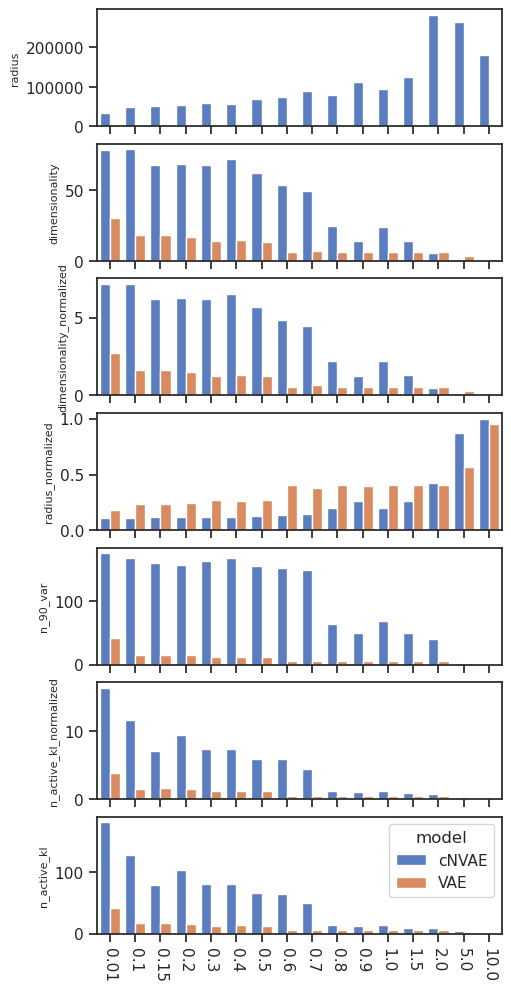

In [6]:
measures = list(df['measure'].unique())
fig, axes = create_figure(
    len(measures), 1,
    (5, 1.4 * len(measures)),
    sharex='all',
    layout='constrained',
)

_df = df.loc[df['beta'] != 'ae']
_df_ae = df.loc[df['beta'] == 'ae']
_pal = {
    k: v for k, v in pal_model.items()
    if k in _df['model'].unique()
}
_pal_ae = {
    k: v for k, v in pal_model.items()
    if k in _df_ae['model'].unique()
}
for i, m in enumerate(measures):
    ax = axes.flat[i]
    sns.barplot(
        data=_df.loc[_df['measure'] == m],
        x='beta',
        y='value',
        hue='model',
        palette=_pal,
        ax=ax,
    )
    ax.set_ylabel(m, fontsize=8)
    ax.set_xlabel('')
    leg = ax.get_legend()
    if i < len(measures) - 1:
        leg.remove()
axes[-1].tick_params(axis='x', rotation=-90)
plt.show()

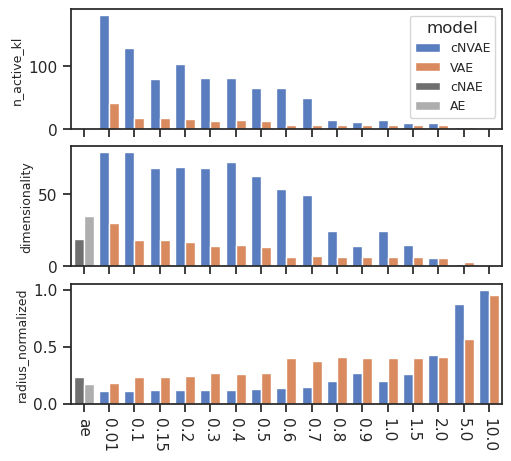

In [7]:
betas = get_betas(df)
measures = ['n_active_kl', 'dimensionality', 'radius_normalized']
fig, axes = create_figure(
    len(measures), 1,
    (5, 1.5 * len(measures)),
    sharex='all',
    layout='constrained',
)

_df = df.loc[df['beta'] != 'ae']
_df_ae = df.loc[df['beta'] == 'ae']
_pal = {
    k: v for k, v in pal_model.items()
    if k in _df['model'].unique()
}
_pal_ae = {
    k: v for k, v in pal_model.items()
    if k in _df_ae['model'].unique()
}
for i, m in enumerate(measures):
    ax = axes.flat[i]
    sns.barplot(
        data=_df.loc[_df['measure'] == m],
        x='beta',
        y='value',
        hue='model',
        palette=_pal,
        order=betas,
        ax=ax,
    )
    sns.barplot(
        data=_df_ae.loc[_df_ae['measure'] == m],
        x='beta',
        y='value',
        hue='model',
        palette=_pal_ae,
        order=betas,
        ax=ax,
    )
    ax.set_ylabel(m, fontsize=9)
    ax.set_xlabel('')
    leg = ax.get_legend()
    if i > 0:
        leg.remove()
    else:
        sns.move_legend(ax, 'upper right', fontsize=9)
        leg = ax.get_legend()
        # bbox TODO
axes[-1].tick_params(axis='x', rotation=-90)
plt.show()

In [8]:
_df = df.loc[df['model'] == 'cNVAE']
r = _df.loc[df['measure'] == 'radius_normalized', 'value'].values
d = _df.loc[df['measure'] == 'dimensionality', 'value'].values
n = _df.loc[df['measure'] == 'n_active_kl', 'value'].values

In [9]:
sp_stats.pearsonr(d, n)

PearsonRResult(statistic=0.9039843078866553, pvalue=1.5599403803105083e-06)

In [10]:
sp_stats.pearsonr(d, 1 / r)

PearsonRResult(statistic=0.9818513688097144, pvalue=1.6575958007353305e-11)

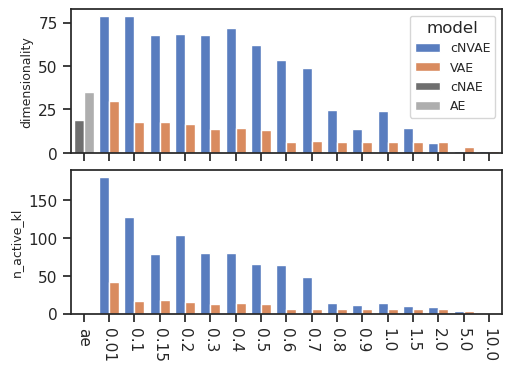

In [12]:
betas = get_betas(df)
measures = [
    'dimensionality',
    'n_active_kl',
]
fig, axes = create_figure(
    len(measures), 1,
    (5, 1.8 * len(measures)),
    sharex='all',
    layout='constrained',
)

_df = df.loc[df['beta'] != 'ae']
_df_ae = df.loc[df['beta'] == 'ae']
_pal = {
    k: v for k, v in pal_model.items()
    if k in _df['model'].unique()
}
_pal_ae = {
    k: v for k, v in pal_model.items()
    if k in _df_ae['model'].unique()
}
for i, m in enumerate(measures):
    ax = axes.flat[i]
    sns.barplot(
        data=_df.loc[_df['measure'] == m],
        x='beta',
        y='value',
        hue='model',
        palette=_pal,
        order=betas,
        ax=ax,
    )
    sns.barplot(
        data=_df_ae.loc[_df_ae['measure'] == m],
        x='beta',
        y='value',
        hue='model',
        palette=_pal_ae,
        order=betas,
        ax=ax,
    )
    ax.set_ylabel(m, fontsize=9)
    ax.set_xlabel('')
    leg = ax.get_legend()
    if i > 0:
        leg.remove()
    else:
        sns.move_legend(ax, 'upper right', fontsize=9)
        leg = ax.get_legend()
        # bbox TODO
axes[-1].tick_params(axis='x', rotation=-90)
plt.show()

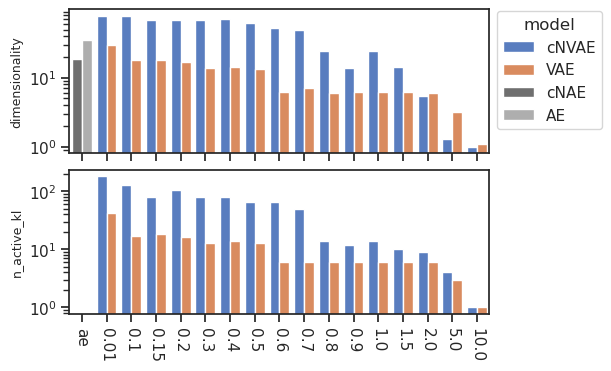

In [17]:
betas = get_betas(df)
measures = [
    'dimensionality',
    'n_active_kl',
]
fig, axes = create_figure(
    len(measures), 1,
    (6, 1.8 * len(measures)),
    sharex='all',
    layout='constrained',
)

_df = df.loc[df['beta'] != 'ae']
_df_ae = df.loc[df['beta'] == 'ae']
_pal = {
    k: v for k, v in pal_model.items()
    if k in _df['model'].unique()
}
_pal_ae = {
    k: v for k, v in pal_model.items()
    if k in _df_ae['model'].unique()
}
for i, m in enumerate(measures):
    ax = axes.flat[i]
    sns.barplot(
        data=_df.loc[_df['measure'] == m],
        x='beta',
        y='value',
        hue='model',
        palette=_pal,
        order=betas,
        ax=ax,
    )
    sns.barplot(
        data=_df_ae.loc[_df_ae['measure'] == m],
        x='beta',
        y='value',
        hue='model',
        palette=_pal_ae,
        order=betas,
        ax=ax,
    )
    ax.set_yscale('log')
    ax.set_ylabel(m, fontsize=9)
    ax.set_xlabel('')
    leg = ax.get_legend()
    if i > 0:
        leg.remove()
    else:
        # sns.move_legend(ax, 'upper right', fontsize=9)
        # leg = ax.get_legend()
        leg.set_bbox_to_anchor((1, 1.04))
axes[-1].tick_params(axis='x', rotation=-90)
plt.show()

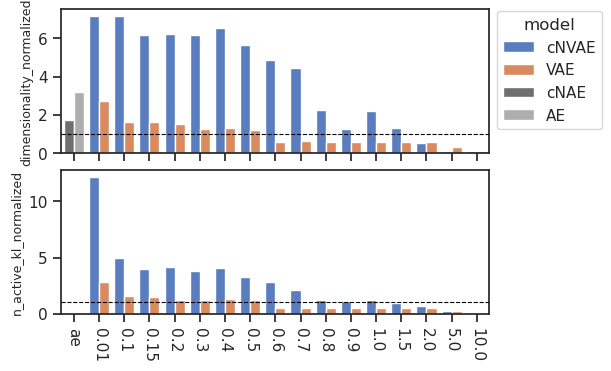

In [21]:
betas = get_betas(df)
measures = [
    'dimensionality_normalized',
    'n_active_kl_normalized',
]
fig, axes = create_figure(
    len(measures), 1,
    (6, 1.8 * len(measures)),
    sharex='all',
    layout='constrained',
)

_df = df.loc[df['beta'] != 'ae']
_df_ae = df.loc[df['beta'] == 'ae']
_pal = {
    k: v for k, v in pal_model.items()
    if k in _df['model'].unique()
}
_pal_ae = {
    k: v for k, v in pal_model.items()
    if k in _df_ae['model'].unique()
}
for i, m in enumerate(measures):
    ax = axes.flat[i]
    ax.axhline(1, color='k', ls='--', lw=0.8, zorder=3)
    sns.barplot(
        data=_df.loc[_df['measure'] == m],
        x='beta',
        y='value',
        hue='model',
        palette=_pal,
        order=betas,
        ax=ax,
    )
    sns.barplot(
        data=_df_ae.loc[_df_ae['measure'] == m],
        x='beta',
        y='value',
        hue='model',
        palette=_pal_ae,
        order=betas,
        ax=ax,
    )
    ax.set_yscale('linear')
    ax.set_ylabel(m, fontsize=9)
    ax.set_xlabel('')
    leg = ax.get_legend()
    if i > 0:
        leg.remove()
    else:
        # sns.move_legend(ax, 'upper right', fontsize=9)
        # leg = ax.get_legend()
        leg.set_bbox_to_anchor((1, 1.04))
axes[-1].tick_params(axis='x', rotation=-90)
plt.show()

0.01

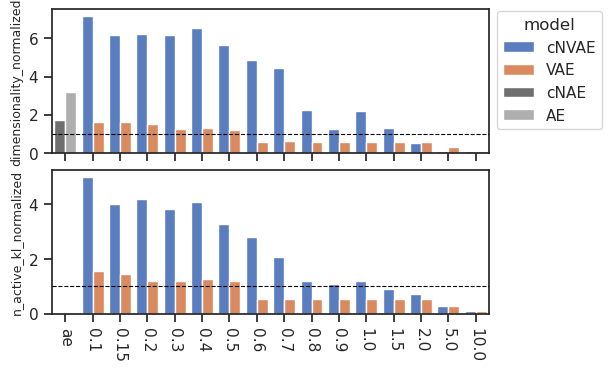

In [25]:
betas = get_betas(df)
betas.pop(betas.index(0.01))
measures = [
    'dimensionality_normalized',
    'n_active_kl_normalized',
]
fig, axes = create_figure(
    len(measures), 1,
    (6, 1.8 * len(measures)),
    sharex='all',
    layout='constrained',
)

_df = df.loc[~df['beta'].isin(['ae', 0.01])]
_df_ae = df.loc[df['beta'] == 'ae']
_pal = {
    k: v for k, v in pal_model.items()
    if k in _df['model'].unique()
}
_pal_ae = {
    k: v for k, v in pal_model.items()
    if k in _df_ae['model'].unique()
}
for i, m in enumerate(measures):
    ax = axes.flat[i]
    ax.axhline(1, color='k', ls='--', lw=0.8, zorder=3)
    sns.barplot(
        data=_df.loc[_df['measure'] == m],
        x='beta',
        y='value',
        hue='model',
        palette=_pal,
        order=betas,
        ax=ax,
    )
    sns.barplot(
        data=_df_ae.loc[_df_ae['measure'] == m],
        x='beta',
        y='value',
        hue='model',
        palette=_pal_ae,
        order=betas,
        ax=ax,
    )
    ax.set_yscale('linear')
    ax.set_ylabel(m, fontsize=9)
    ax.set_xlabel('')
    leg = ax.get_legend()
    if i > 0:
        leg.remove()
    else:
        # sns.move_legend(ax, 'upper right', fontsize=9)
        # leg = ax.get_legend()
        leg.set_bbox_to_anchor((1, 1.04))
axes[-1].tick_params(axis='x', rotation=-90)
plt.show()